# CONTEXTO DO PROBLEMA

A **Insurance All** é uma empresa que fornece seguro de saúde para seus clientes e o time de produtos está analisando a possibilidade de oferecer aos assegurados, um novo produto: Um seguro de automóveis.

Assim como o seguro de saúde, os clientes desse novo plano de seguro de automóveis precisam pagar um valor anualmente à Insurance All para obter um valor assegurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

A Insurance All fez uma pesquisa com cerca de 380 mil clientes sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

O time de produtos selecionou 127 mil novos clientes que não responderam a pesquisa para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas.

Contudo, o time de vendas tem uma capacidade de realizar 20 mil ligações dentro do período da campanha.

# O PROBLEMA

Nesse contexto, você foi contratado como um consultor de Ciência de Dados para construir um modelo que prediz se o cliente estaria ou não interessado no seguro de automóvel. 

Com a sua solução, o time de vendas espera conseguir priorizar as pessoas com maior interesse no novo produto e assim, otimizar a campanha realizando apenas contatos aos clientes mais propensos a realizar a compra.


Como resultado da sua consultoria, você precisará entregar um relatório contendo algumas análises e respostas às seguintes perguntas:

**1.** Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

**2.** Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

**3.** E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

**4.** Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

# ENTENDIMENTO DO PROBLEMA

- **Motivação:**
    - A empresa vai realizar uma campanha para um novo produto (seguro de automóvel).


- **Causa Raiz do Problema:**
    - Identificar clientes com maior interesse no seguro do automóvel.


- **Dados para Resolver o Problema:**
    - Os dados estão armazenados em um banco de dados PostgresSQL na AWS.
    

- **Fomato da Solução:**

    - **Granularidade:** Previsão da probabilidade de compra por cliente.
    - **Tipo de Problema:** Previsão da probabilidade de compra.
    - **Potênciais Métodos:** Ranqueamento, Classificação.
    - **Formato da Entrega:** NÃO DEFINIDO

# 0.0 IMPORTS

In [95]:
# Colect and manipulation
import psycopg2 as pg
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistic and math
from scipy import stats
import numpy as np

## 0.1 Funções Auxiliares

In [90]:
# correlation categories
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) **2 / (n-1)
    rcorr = r - (r-1) **2 / (n-1)
    
    return np.sqrt((chi2_corr / n) / (min(kcorr-1, rcorr-1)))


# Show matrix correlation
def show_matrix(col, data, output='list'):

    rows = []
    index = []
    columns = []

    for c in data.columns:

        result = cramer_v(x=data[str(col)], y=data[str(c)])

        rows.append(result)
        index.append(str(c))
        columns.append(str(col))
        
    if output == 'list':
        return rows
    
    elif output == 'dict':
        return pd.DataFrame(rows, index=index, columns=[str(col)])

## 0.2 Coleta de Dados

In [2]:
# Creadentials
HOST     = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
PORT     ='5432'
USER     ='member'
DATABASE ='comunidadedsdb'
PASSWORD = 'cdspa'


try: # Connect DB
    conn = pg.connect(
        host=HOST,port=PORT, database=DATABASE, user=USER, password=PASSWORD
    )
    
    # Query data
    query = """
        SELECT *
        FROM pa004.users u LEFT JOIN pa004.vehicle v on (u.id = v.id)
                           LEFT JOIN pa004.insurance i on (u.id = i.id)  
    """
    
    # Read in sql and parse to Dataframe
    df = pd.read_sql(query, conn)
    df = df.drop(df.columns[[5]], axis=1)
    conn.close()
    
except Exception as e: # Connection Error  
    print("Database connection failed due to {}".format(e))
    
df.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [3]:
# Copy data
df1 = df.copy()

print(f'Nº Rows: {df1.shape[0]}')
print(f'Nº Columns: {df1.shape[1]}')

Nº Rows: 381109
Nº Columns: 11


## 1.2 Tipo de Dados

In [4]:
df1.dtypes

gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Verificação de Dados Faltantes

In [5]:
df1.isna().sum()

gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 Mudança de Tipo nos Dados

In [6]:
# vehicle demage - str to int
df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype('int64')

## 1.5 Estatistica Descritiva

### 1.5.1 Atributos Numéricos

In [7]:
# Select numerical data
numerical = df1.select_dtypes(include=['int64', 'float64'])

# Calculate kurtosis and skew
kurtosis = numerical.apply(lambda x: x.skew())
skew = numerical.apply(lambda x: x.kurtosis())

# Describe data
describe = numerical.describe().T

# Add skew and kurtosis in describe
describe['skew'] = skew
describe['kurtosis'] = kurtosis

# Show describe
describe

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,-0.565655,0.672539
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,-0.867857,-0.115266
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,-0.970810,-0.900008
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,464.354302,-21.595182
vehicle_damage,381109.0,0.504877,0.499977,0.0,0.0,1.0,1.0,1.0,-1.999630,-0.019507
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,-1.971871,0.167747
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,34.004569,1.766087
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,-1.200688,0.003030
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,3.298788,2.301906


**Insight:**

<ins>Distribuição</ins>: Em geral, os dados não possuem erros ou inconsistências e, no total, os dados não parecem estar tão dispensos.

<ins>Negócio</ins>: Os clientes possuem idade média de 38 anos e há clientes na base entre 20 e 85 anos. 75% da base já possuiu previamente algum tipo de seguro com a Insurance All. Em média, os clientes pagaram 30K para obter cobertura de seguro e o valor máximo pago foi de  540K. Em média, há 112 formas de entrar em contato com os clientes e, em média, há clientes durante 154 dias e clientes mais recentes possuem 10 dias como clientes. E com a pesquisa feita pela empresa, 75% das pessoas informaram que não compraria o seguro de automóvel.

### 1.5.2 Atributos Categóricos

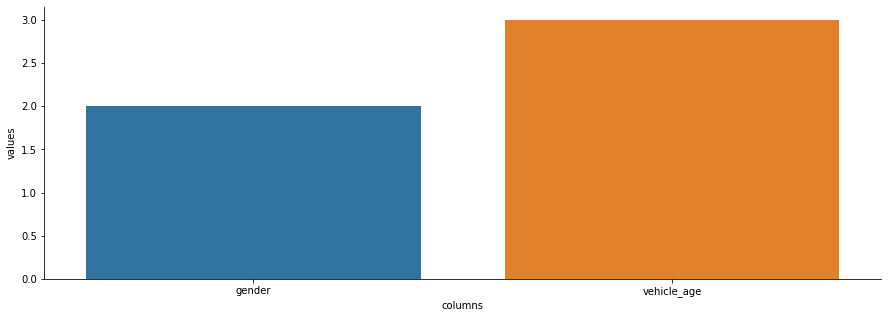

In [8]:
# Select categorical data
categorical = df1.select_dtypes(include=['object'])

# Count possible categorical values
unique_values = categorical.apply(lambda x: len(x.unique())).reset_index().rename(
    columns={'index': 'columns', 0: 'values'}).sort_values(by='values')

# Figure
plt.figure(figsize=(15, 5))
sns.barplot(x='columns', y='values', data=unique_values)
sns.despine(right=True)

**Insight:**

As variáveis categóricas possuem um range entre 2 e 3 dos possíveis valores.

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="img/mind_map.PNG" width="1000" title="img-principal">
</p>

## 2.2 Lista de Hipóteses

### 2.2.1 Hipóteses Automóvel

**1.** Pessoas com automóveis quitados possuem interesse em contratar um seguro.

**2.** Pessoas com automóveis de trabalho não possuem interesse em contratar um seguro.

**3.** Pessoas com automóveis recém comprados possuem interesse em contratar um segeuro.

**4.** Pessoas com automóveis mais antigos não possuem interesse em contratar um seguro.

**5.** Pessoas com automóveis mais caros possuem interesse em contratar um seguro.

### 2.2.2 Hipóteses Valor

**1.** Pessoas não estão interessadas em contratar seguro com valoranual maior que 30K.

**2.** Pessoas estão interessas em contratar seguro com valor mensal menor que 2k.

**3.** Pessoas que investem mais em conservação do automóvel estão interessadas em contratar um seguro.

**4.** Pessoas que obtem um valor de cobertura do seguro acima de 100k estão interessados em contratar um seguro.

### 2.2.3 Hipóteses Cliente

**1.** Pessoas que já possuiram seu automóvel roubado, estão interessadas em contratar um seguro.

**2.** Pessoas que já tiveram seu carro batido, estão interessados em contratar um seguro.

**3.** Pessoas com idade maior que 30, estão interessadas em contratar um seguro.

**3.** Pessoas do sexo feminino são mais interessadas em contratar um seguro.

**4.** Pessoas que já tiveram aciendente grave, estão mais interessadas em contratar um seguro.

### 2.2.4 Hipóteses Região

**1.** Pessoas que estão localizadas em área de risco, estão mais interessadas em contratar um seguro.

**2.** Pessoas que deixam o automóvel em condomino, estão menos interessadas em contratar um seguro.

**3.** Pessoas que deixam o automóvel na rua, estão mais interessadas em contratar um seguro.

**4.** Pessoas que estão localizadas em áreas de grande circulação de veículos, possuem maior interesse em contratar um seguro.

## 2.3 Lista Final de Hipóteses

**1.** Pessoas com automóveis mais antigos não possuem interesse em contratar um seguro.

**2.** Pessoas não estão interessadas em contratar seguro com valor anual maior que 30K. 

**3.** Pessoas estão interessas em contratar seguro com valor mensal menor que 2k. 

**4.** Pessoas que investem mais em conservação do automóvel estão interessadas em contratar um seguro. 

**5.** Pessoas com idade maior que 30, estão interessadas em contratar um seguro. 

**6.** Pessoas do sexo feminino são mais interessadas em contratar um seguro. 

**7.** Pessoas que não possuem CNH, não estão mais interessadas em contratar um seguro.

**8.** Pessoas que já possuiram seguro em algum momento da vida, estão mais interessados em contratar o seguro da Insurance All.

**9.** Pessoas que são clientes a mais de 60 dias, estão mais interessadas em contratar um seguro.

## 2.4 Feature Engineering

In [9]:
# Copy dataframe
df2 = df1.copy()

# monthly_premium: Monthly amount paid
df2['monthly_premium'] = df2['annual_premium'].apply(lambda x: x / 12).round()

# age_category: over 30 years old or under and equal 30 years old.
df2['age_category'] = df2['age'].apply(lambda x: 'over_30_years' if x > 30 else 'between_30_years')

# vintage_category: between 60 day or more than 60 days.
df2['vintage_category'] = df2['vintage'].apply(lambda x: 'between_60_days' if x < 60 else 'more_60_days')

# 3.0 <s>FILTRAGEM DE DADOS<s>

## 3.1 <s>Filtragem de Linhas<s>

## 3.2 <s>Filtragem de Colunas<s>

# 4.0 EDA

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

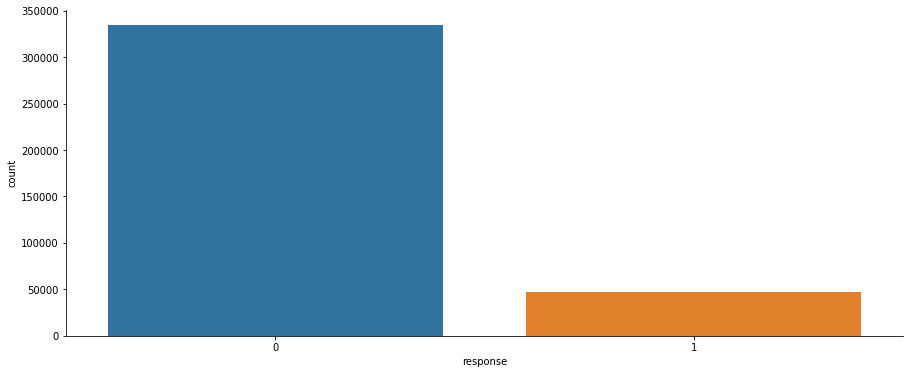

In [14]:
# Copy dataframe
df4 = df2.copy()

# Figure 
plt.figure(figsize=(15, 6))
sns.countplot(x='response', data=df4)
sns.despine(right=True);

**Insight:**

87% das pessoas informaram não estar interessadas em um seguro de automóvel e 12% informaram que estão. A distribuição dos dados na variável resposta estão desbalanceados.

### 4.1.2 Variável Numérica

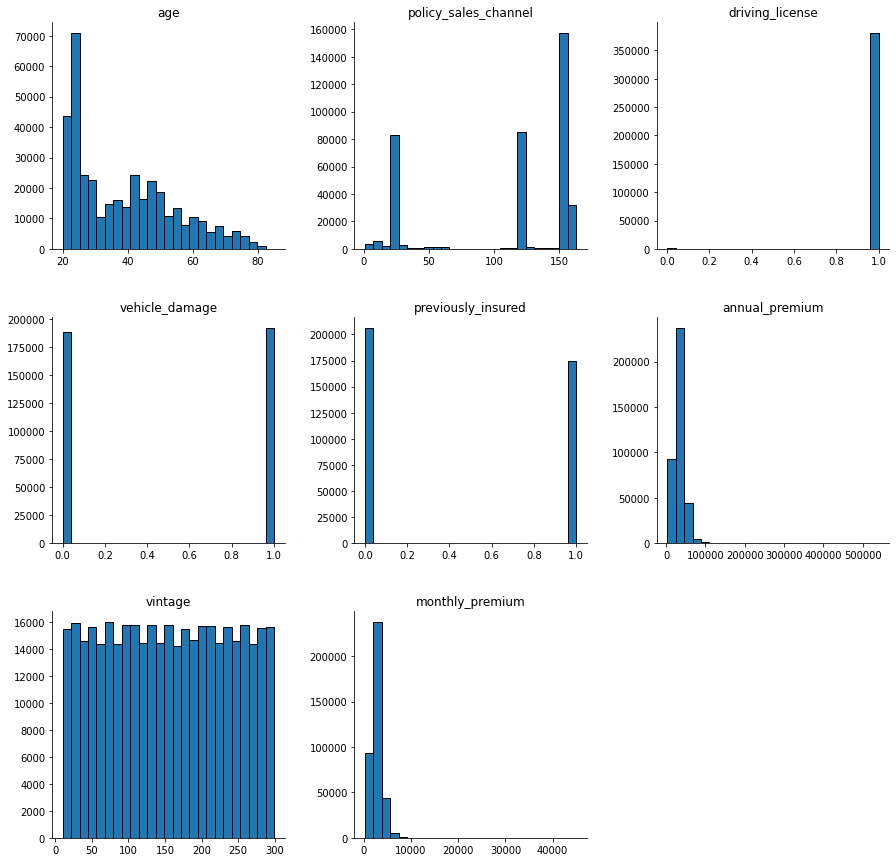

In [22]:
# Filter numerical data
numerical = df4.select_dtypes(include=['int64', 'float64']).drop(columns=['response', 'region_code'])

# Figure
numerical.hist(grid=False, bins=25, ec='k', figsize=(15, 15))
sns.despine(right=True);

**Insight:**


- age: Há um pico maior de pessoas com idades mais novas, na casa dos 20 anos. E há menor quantidade de pessoas com idade acima de 60 anos.


- policy_sales_channel: há maior quantidade de pessoas com cerca de 150 formas de contato.


- driving_license: Há maior quantidade de pessoas que possuem licença para dirigir.


- vehicle_damage: Os danos nos veículos estão bem distribuídos, posssuindo praticamente a mesma quantidade de pessoas que tem danos no veículo e que não tem.


- previously_insured: A maior parte das pessoas nunca foram clientes da empresa Insurance All.


- annual_premium: A maior parte das pessoas tem o preço do seguro anual em cerca de 50k.

### 4.1.3 Variável Categórica

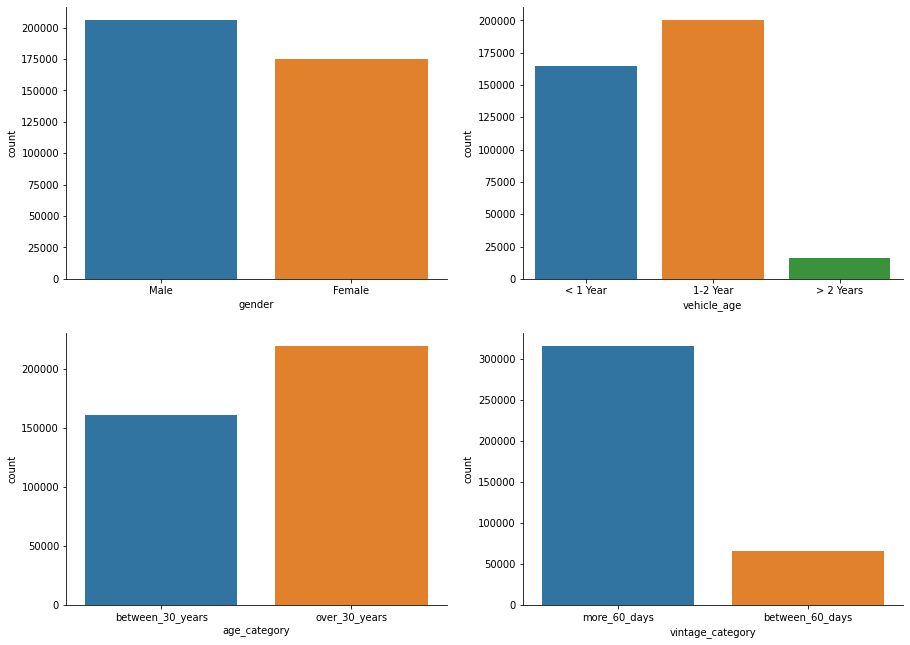

In [12]:
# Filter categorical data
categorical = df4.select_dtypes(include=['object'])

# Figure 1
plt.figure(figsize=(15, 11))
plt.subplot(2, 2, 1)
sns.countplot(x='gender', data=df4)

# Figure 2
plt.subplot(2, 2, 2)
sns.countplot(x='vehicle_age', data=df4)

# Figure 3
plt.subplot(2, 2, 3)
sns.countplot(x='age_category', data=df4)

# Figure 4
plt.subplot(2, 2, 4)
sns.countplot(x='vintage_category', data=df4)
sns.despine(right=True);

**Insight:**

- gender: A maior parte das pessoas são do sexo masculino.


- vehicle_age : A maior parte das pessoas possuem automóveis com idade entre 1 e 2 anos, e, a menor parte, possui idade maior que 2 anos.


- age_category: Na categoria de idade, há maior quantidade de pessoas acima dos 30 anos, devido ao range ser de 30 anos a 80 anos (valor maximo). E a categoria entre 30 anos possuir um range de 10 idades, apenas. 


- vintage_category: A maior parte das pessoas são clientes a mais de 60 dias.

## 4.2 Análise Bivariada

### H1. Pessoas com automóveis mais antigos não possuem interesse em contratar um seguro.

**VERDADEIRA** Pessoas com automóveis mais antigos NÃO possuem interesse em contratar um seguro.

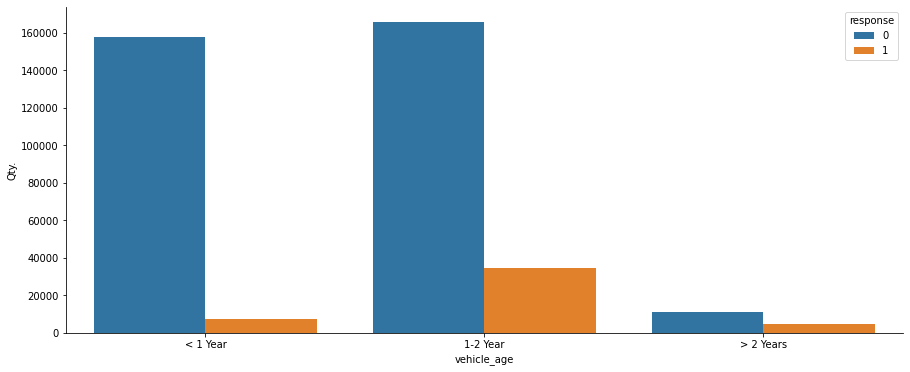

In [69]:
plt.figure(figsize=(15, 6))
sns.countplot(x='vehicle_age', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True)

### H2. Pessoas não estão interessadas em contratar seguro com valor anual maior que 30K. 

**FALSA** Pessoas estão interessadas em contratar seguro com valor anual MAIOR que 30K.  

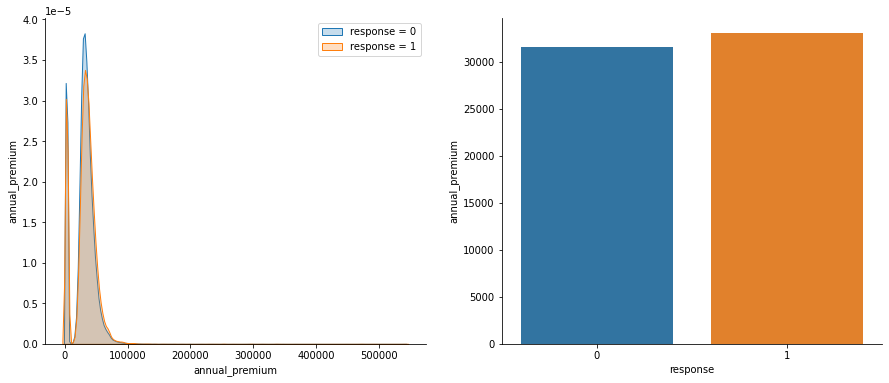

In [49]:
# -- Figure 1
not_interest = df4[df4['response'] == 0] # Filter response = 0
interest = df4[df4['response'] == 1] # Filter response = 1

# Create figure 1
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(x=not_interest['annual_premium'], label='response = 0', shade=True)
sns.kdeplot(x=interest['annual_premium'], label='response = 1', shade=True)
plt.legend()
plt.ylabel('annual_premium')

# -- Figure 2
aux1 = df4['annual_premium'].groupby(df4['response']).median().reset_index() # Group annual_premium by response

# Create Figure 2
plt.subplot(1, 2, 2)
sns.barplot(x='response', y='annual_premium', data=aux1)
sns.despine(right=True);

### H3. Pessoas estão interessas em contratar seguro com valor mensal menor que 2k.

**FALSA** Pessoas estão interessas em contratar seguro com valor mensal MAIOR que 2k.

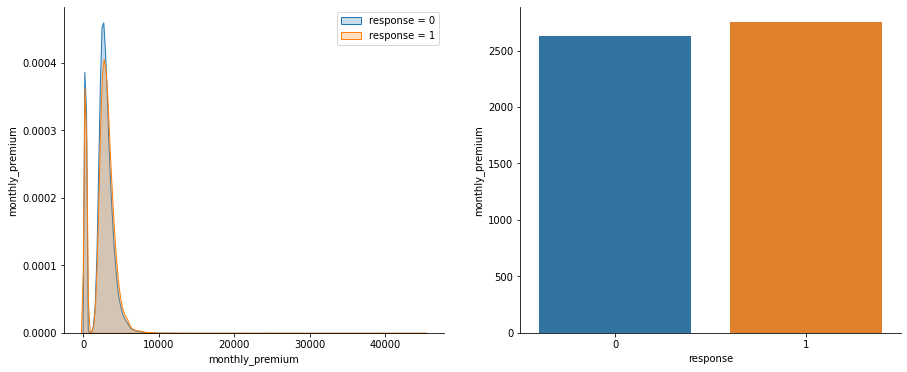

In [64]:
# -- Figure 1
not_interest = df4[df4['response'] == 0] # Filter response = 0
interest = df4[df4['response'] == 1] # Filter response = 1

# Create figure 1
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(x=not_interest['monthly_premium'], label='response = 0', shade=True)
sns.kdeplot(x=interest['monthly_premium'], label='response = 1', shade=True)
plt.legend()
plt.ylabel('monthly_premium')

# -- Figure 2
aux1 = df4['monthly_premium'].groupby(df4['response']).median().reset_index() # Group monthly_premium by response

# Create Figure 2
plt.subplot(1, 2, 2)
sns.barplot(x='response', y='monthly_premium', data=aux1)
sns.despine(right=True);

### H4. Pessoas que investem mais em conservação do automóvel estão interessadas em contratar um seguro.

**FALSA** Pessoas que possuem automóvel menos conservado (com dano), possuem maior interesse em contratar um seguro. 

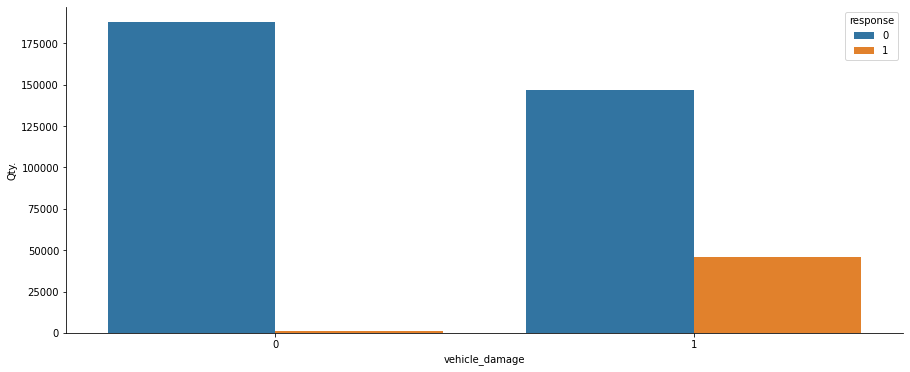

In [68]:
plt.figure(figsize=(15, 6))
sns.countplot(x='vehicle_damage', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H5. Pessoas com idade maior que 30, estão interessadas em contratar um seguro.

**VERDADEIRA** Pessoas com idade maior que 30 anos, estão mais interessadas em contratar um seguro do que pessoas com idade menor que 30.

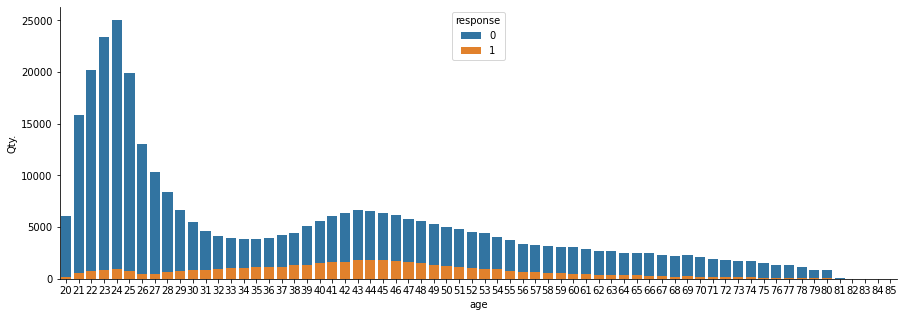

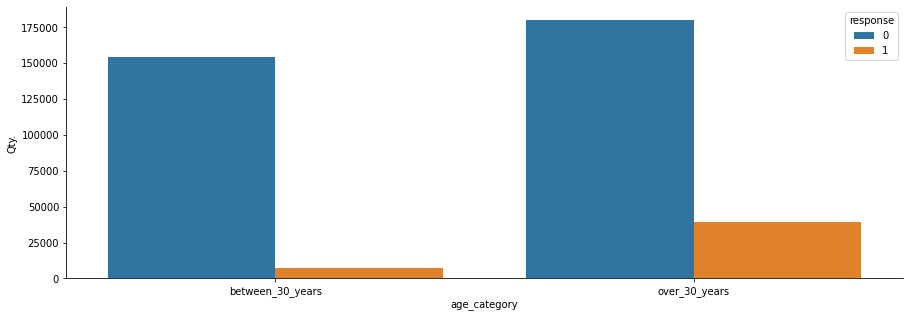

In [67]:
plt.figure(figsize=(15, 5))
sns.countplot(x='age', data=df4, hue='response', dodge=False)
plt.ylabel('Qty.')
sns.despine(right=True)

plt.figure(figsize=(15, 5))
sns.countplot(x='age_category', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H6. Pessoas do sexo feminino são mais interessadas em contratar um seguro.

**FALSA** Pessoas do sexo Masculino são mais interessdas do que o sexo Feminino em contratar um seguro.

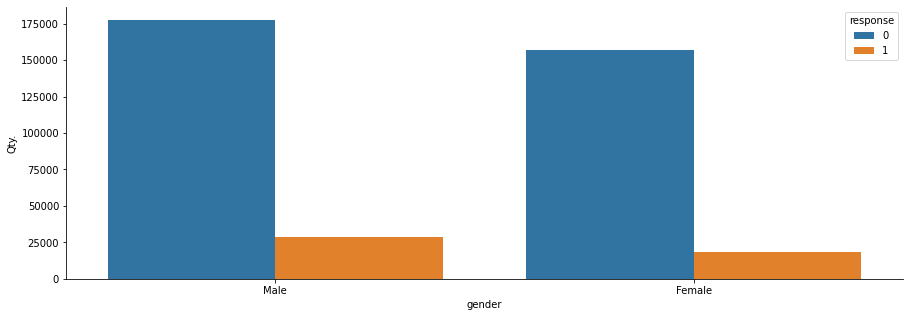

In [70]:
plt.figure(figsize=(15, 5))
sns.countplot(x='gender', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H7. Pessoas que não possuem licença para dirigir, estão menos interessadas em contratar um seguro.

**VERDADEIRA** Pessoas que não possuem licença para dirigir, estão menos interessadas em contratar um seguro.

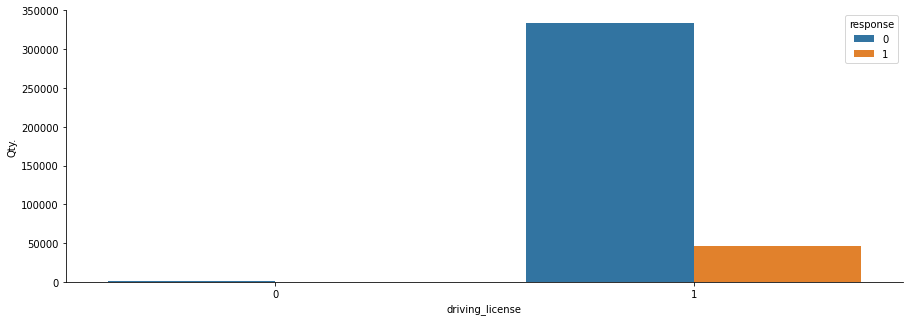

In [75]:
plt.figure(figsize=(15, 5))
sns.countplot(x='driving_license', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H8. Pessoas que já possuiram seguro em algum momento da vida, estão mais interessados em contratar o seguro da Insurance All.

**FALSA** Pessoas que NUNCA possuiram seguro em algum momento da vida, estão mais interessados em contratar o seguro da Insurance All.

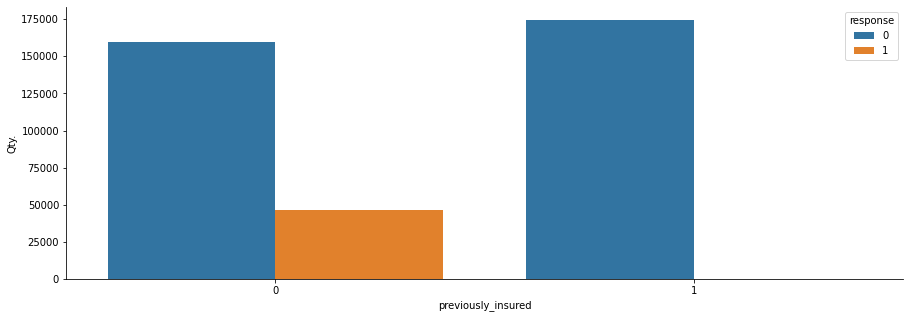

In [82]:
plt.figure(figsize=(15, 5))
sns.countplot(x='previously_insured', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

### H9. Pessoas que são clientes a mais de 60 dias, estão mais interessadas em contratar um seguro.

**VERDADEIRA** Pessoas que são clientes a mais de 60 dias, estão mais interessadas em contratar um seguro.

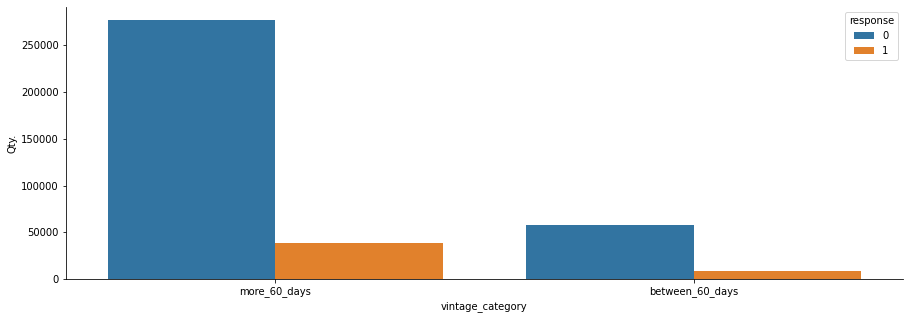

In [81]:
plt.figure(figsize=(15, 5))
sns.countplot(x='vintage_category', data=df4, hue='response')
plt.ylabel('Qty.')
sns.despine(right=True);

## 4.3 Análise Multivariada

### 4.3.1 Variável Numérica

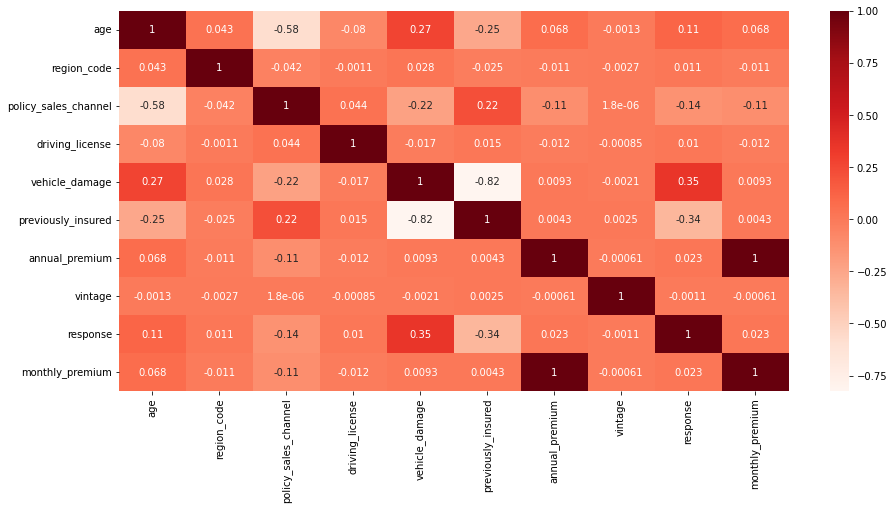

In [98]:
# Filter numerical data
numerical = df4.select_dtypes(include=['int64', 'float64'])

# Figure
plt.figure(figsize=(15, 7))
sns.heatmap(df4.corr(method='pearson'), annot=True, cmap='Reds');

**Insight:**

Nas variaveis numéricas, há correlação média entre o dano do automóvel e a idade do dono, também hpa com o dano do automóvel e se ele já possuiu seguro na vida. Além disso, há correlação média entre o cliente já possuir algum seguro na vida e a quantidade de canais de contato que a Insurance All possui dele(a).

Sobre a pessoas estar interessada no seguro, há correlação média entre o dano do veículo e o interesse por possuir o seguro.

### 4.3.2 Variável Categórica

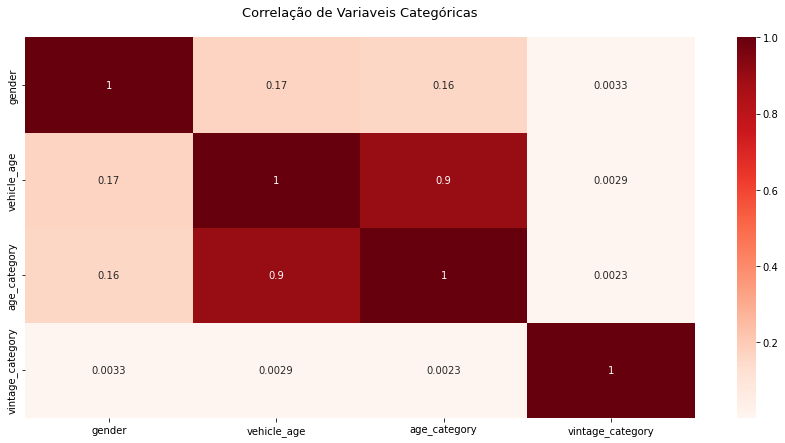

In [97]:
# Categorical data
categorical = df4.select_dtypes(include=['object'])

# Apply correlation categories
matrix = show_matrix(data=categorical, col='gender', output='dict')
data_columns = categorical.iloc[:, 1:]

for c in data_columns.columns:
    matrix[c] = show_matrix(data=categorical, col=c, output='list')

# Figure
plt.figure(figsize=(15, 7))
sns.heatmap(matrix, annot=True, cmap='Reds')
plt.title('Correlação de Variaveis Categóricas\n', fontsize=13);

**Insight:**

Nas variaveis categóricas, há pouca correlação para ser observada, a únca que chama atenção é uma correlação fraca entre a idade da pessoa com a idade do veículo.

# Dicionario de dados

Gênero : gender

Idade : age

Code da região : region_code

Qtd. de contato : policy_sales_channel

CNH : driving_license

Idade do veículo : vehicle_age

Danos do veículo : vehicle_damage

Se a pessoa já teve algum seguro (na vida): previously_insured

Valor da cobertura do seguro anual : annual_premium

Tempo em que a pessoas é cliente em dias : vintage

Se o cliente está interessado ou não no seguro : response